In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm,tree,linear_model,dummy,ensemble
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

In [2]:
path = './history/'
elements = pd.read_csv('./elements.csv')
elements.head()

,Unnamed: 0,id,web_name,element_type,team,now_cost
0,0,1,Mustafi,2,1,52
1,1,2,Bellerín,2,1,54
2,2,3,Kolasinac,2,1,53
3,3,4,Maitland-Niles,2,1,47
4,4,5,Sokratis,2,1,50


In [3]:
GKP = pd.DataFrame()
DEF = pd.DataFrame()
MID = pd.DataFrame()
FWD = pd.DataFrame()
for i,player in elements.iterrows():
    df = pd.read_csv(path+'{}.csv'.format(player.id))
    df['point_next'] = df.total_points.shift(-1)
#     df[df.was_home == True]['team_score'] = df[df.was_home == True].team_h_score
#     df[df.was_home == False]['team_score'] = df[df.was_home == False].team_a_score
#     df[df.was_home == True]['team_conceded'] = df[df.was_home == True].team_a_score
#     df[df.was_home == False]['team_conceded'] = df[df.was_home == False].team_h_score
    df= df.drop(df.tail(1).index)
    df['team']=player.team
    df = df.drop(columns=['Unnamed: 0','kickoff_time', 'fixture'])
    if player.element_type == 1:
        df = df.drop(columns=['goals_scored', 'assists','penalties_missed','creativity','threat'])
        if df.sum().minutes != 0:
            GKP = GKP.append(df)
    elif player.element_type == 2:
        df = df.drop(columns=['saves','penalties_saved'])
        
        DEF = DEF.append(df)
    elif player.element_type == 3:
        df = df.drop(columns=['saves','penalties_saved'])
        MID = MID.append(df)
    else:
        df = df.drop(columns=['saves','penalties_saved'])
        FWD = FWD.append(df)
        
GKP = GKP.reset_index(drop=True)
DEF = DEF.reset_index(drop=True)
MID = MID.reset_index(drop=True)
FWD = FWD.reset_index(drop=True)

element               27
opponent_team         20
total_points          13
was_home               2
team_h_score           7
team_a_score           7
round                 11
minutes               10
clean_sheets           2
goals_conceded         8
own_goals              1
penalties_saved        3
yellow_cards           2
red_cards              1
saves                 11
bonus                  4
bps                   36
influence            147
ict_index             61
value                 18
transfers_balance    271
selected             297
transfers_in         267
transfers_out        269
point_next            13
team                  20
dtype: int64
9
0
0
2


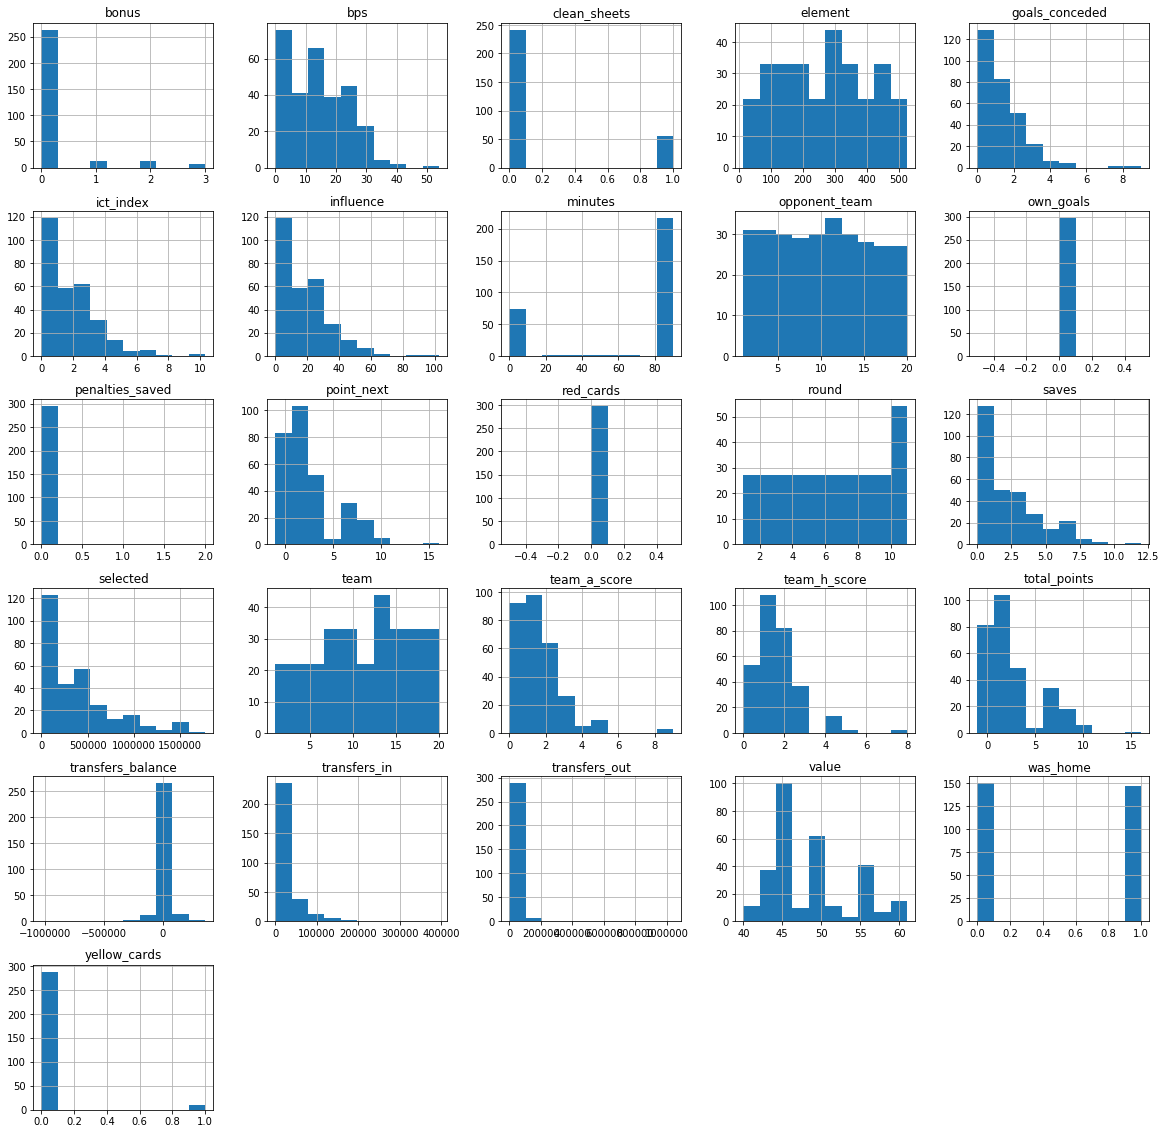

In [4]:
GKP.was_home = GKP.was_home.astype('int64')
GKP.hist(figsize=(20,20))
print(GKP.nunique()) #only 30 goalkeepers played this season
print(GKP.loc[GKP.yellow_cards == 1].shape[0]) #9 yellow_cards for goalkeepers up to now
print(GKP.loc[GKP.red_cards == 1].shape[0]) # No red card for goalkeepers up to now
print(GKP.loc[GKP.own_goals == 1].shape[0]) # No own goal up to now
print(GKP.loc[GKP.penalties_saved == 1].shape[0]) #

In [5]:
sample = GKP[GKP.element == 14]
sample
# sample.goals_scored = 

,element,opponent_team,total_points,was_home,team_h_score,team_a_score,round,minutes,clean_sheets,goals_conceded,...,bps,influence,ict_index,value,transfers_balance,selected,transfers_in,transfers_out,point_next,team
0,14,13,7,0,0,1,1,90,1,0,...,27,18.0,1.8,50,0,276322,0,0,3.0,1
1,14,5,3,1,2,1,2,90,0,1,...,15,26.4,2.6,50,90465,443302,113328,22863,1.0,1
2,14,10,1,0,3,1,3,90,0,3,...,13,19.0,1.9,50,-41727,409348,23145,64872,3.0,1
3,14,17,3,1,2,2,4,90,0,2,...,21,29.6,3.0,50,-21012,402670,19796,40808,2.0,1
4,14,18,2,0,2,2,5,90,0,2,...,21,45.4,4.5,50,-1074,415601,28035,29109,2.0,1
5,14,2,2,1,3,2,6,90,0,2,...,20,37.4,3.7,50,1093,423237,20277,19184,3.0,1
6,14,12,3,0,1,1,7,90,0,1,...,13,18.6,1.9,50,-26428,397350,7202,33630,6.0,1
7,14,3,6,1,1,0,8,90,1,0,...,24,15.0,1.5,50,17314,422070,31190,13876,2.0,1
8,14,15,2,0,1,0,9,90,0,1,...,14,9.2,0.9,50,25910,453397,39293,13383,1.0,1
9,14,7,1,1,2,2,10,90,0,2,...,13,18.4,1.8,50,-3205,450831,10474,13679,4.0,1


In [6]:
team_agg = pd.DataFrame()
for i in range(1,21):
    team_agg = team_agg.append(pd.read_csv('./agg_team/{}.csv'.format(i)))

In [7]:
team_agg

,Unnamed: 0,GW,goals_conceded,goals_scored,team
0,0,1.0,0.000000,1.000000,1.0
1,1,2.0,0.500000,1.500000,1.0
2,2,3.0,1.333333,1.333333,1.0
3,3,4.0,1.500000,1.500000,1.0
4,4,5.0,1.600000,1.600000,1.0
...,...,...,...,...,...
7,7,8.0,1.375000,1.375000,20.0
8,8,9.0,1.333333,1.333333,20.0
9,9,10.0,1.300000,1.300000,20.0
10,10,11.0,1.272727,1.272727,20.0


In [8]:
sample['team_scored'] = team_agg[team_agg.team == sample.team.unique()[0]].goals_scored
sample['team_conceded'] = team_agg[team_agg.team == sample.team.unique()[0]].goals_conceded
# for i,row in sample.iterrows():
#     print(team_agg[team_agg.team == row.team and team_agg.GW == row.round])
#     sample.loc[i]['opponent_scored'] = team_agg[team_agg.team == row.team and team_agg.GW == row.round].goals_scored
#     sample.loc[i,'opponent_conceded'] = team_agg[team_agg.team == row.team].goals_conceded
sample

/home/a/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/a/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,element,opponent_team,total_points,was_home,team_h_score,team_a_score,round,minutes,clean_sheets,goals_conceded,...,ict_index,value,transfers_balance,selected,transfers_in,transfers_out,point_next,team,team_scored,team_conceded
0,14,13,7,0,0,1,1,90,1,0,...,1.8,50,0,276322,0,0,3.0,1,1.000000,0.000000
1,14,5,3,1,2,1,2,90,0,1,...,2.6,50,90465,443302,113328,22863,1.0,1,1.500000,0.500000
2,14,10,1,0,3,1,3,90,0,3,...,1.9,50,-41727,409348,23145,64872,3.0,1,1.333333,1.333333
3,14,17,3,1,2,2,4,90,0,2,...,3.0,50,-21012,402670,19796,40808,2.0,1,1.500000,1.500000
4,14,18,2,0,2,2,5,90,0,2,...,4.5,50,-1074,415601,28035,29109,2.0,1,1.600000,1.600000
5,14,2,2,1,3,2,6,90,0,2,...,3.7,50,1093,423237,20277,19184,3.0,1,1.833333,1.666667
6,14,12,3,0,1,1,7,90,0,1,...,1.9,50,-26428,397350,7202,33630,6.0,1,1.714286,1.571429
7,14,3,6,1,1,0,8,90,1,0,...,1.5,50,17314,422070,31190,13876,2.0,1,1.625000,1.375000
8,14,15,2,0,1,0,9,90,0,1,...,0.9,50,25910,453397,39293,13383,1.0,1,1.444444,1.333333
9,14,7,1,1,2,2,10,90,0,2,...,1.8,50,-3205,450831,10474,13679,4.0,1,1.500000,1.400000


In [9]:
scaler = MinMaxScaler().fit(sample.drop(columns=['element','opponent_team','team']))
sample_scaled = scaler.transform(sample.drop(columns=['element','opponent_team','team']))
sample_scaled.shape

(11, 25)

In [20]:
X = sample.drop(columns=['element','opponent_team','team','point_next'])
Y = sample['point_next']
X

,total_points,was_home,team_h_score,team_a_score,round,minutes,clean_sheets,goals_conceded,own_goals,penalties_saved,...,bps,influence,ict_index,value,transfers_balance,selected,transfers_in,transfers_out,team_scored,team_conceded
0,7,0,0,1,1,90,1,0,0,0,...,27,18.0,1.8,50,0,276322,0,0,1.000000,0.000000
1,3,1,2,1,2,90,0,1,0,0,...,15,26.4,2.6,50,90465,443302,113328,22863,1.500000,0.500000
2,1,0,3,1,3,90,0,3,0,0,...,13,19.0,1.9,50,-41727,409348,23145,64872,1.333333,1.333333
3,3,1,2,2,4,90,0,2,0,0,...,21,29.6,3.0,50,-21012,402670,19796,40808,1.500000,1.500000
4,2,0,2,2,5,90,0,2,0,0,...,21,45.4,4.5,50,-1074,415601,28035,29109,1.600000,1.600000
5,2,1,3,2,6,90,0,2,0,0,...,20,37.4,3.7,50,1093,423237,20277,19184,1.833333,1.666667
6,3,0,1,1,7,90,0,1,0,0,...,13,18.6,1.9,50,-26428,397350,7202,33630,1.714286,1.571429
7,6,1,1,0,8,90,1,0,0,0,...,24,15.0,1.5,50,17314,422070,31190,13876,1.625000,1.375000
8,2,0,1,0,9,90,0,1,0,0,...,14,9.2,0.9,50,25910,453397,39293,13383,1.444444,1.333333
9,1,1,2,2,10,90,0,2,0,0,...,13,18.4,1.8,50,-3205,450831,10474,13679,1.500000,1.400000


In [44]:
regressor_pipeline = make_pipeline(MinMaxScaler(), svm.SVC(C=1))
error = cross_val_score(regressor_pipeline,X,Y,cv=3,scoring = 'neg_mean_absolute_error')
error.mean()

/home/a/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/home/a/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/a/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/a/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default v

-0.8333333333333334

In [43]:
regressor_pipeline = make_pipeline(MinMaxScaler(), dummy.DummyRegressor(strategy = 'mean'))
error = cross_val_score(regressor_pipeline,X,Y,cv=3,scoring = 'neg_mean_absolute_error')
error.mean()

-1.0833333333333333

In [34]:
regressor_pipeline = make_pipeline(MinMaxScaler(), linear_model.LinearRegression())
error = cross_val_score(regressor_pipeline,X,Y,cv=3,scoring = 'neg_mean_absolute_error')
np.mean(error)

-2.2463583499172515

In [36]:
regressor_pipeline = make_pipeline(MinMaxScaler(), tree.DecisionTreeRegressor())
error = cross_val_score(regressor_pipeline,X,Y,cv=3,scoring = 'neg_mean_absolute_error')
np.mean(error)

-1.3611111111111114

In [35]:
regressor_pipeline = make_pipeline(MinMaxScaler(), ensemble.RandomForestRegressor(n_estimators =2))
error = cross_val_score(regressor_pipeline,X,Y,cv=3,scoring = 'neg_mean_absolute_error')
np.mean(error)

-1.1111111111111112

In [62]:
regressor_pipeline = make_pipeline(MinMaxScaler(),PCA(n_components=5), svm.SVC(C=1))
error = cross_val_score(regressor_pipeline,X,Y,cv=3,scoring = 'neg_mean_absolute_error')
error.mean()

/home/a/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/home/a/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/a/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/a/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default v

-0.7777777777777778

In [61]:
regressor_pipeline = make_pipeline(MinMaxScaler(), PCA(n_components = 6),tree.DecisionTreeRegressor())
error = cross_val_score(regressor_pipeline,X,Y,cv=3,scoring = 'neg_mean_absolute_error')
np.mean(error)

-1.3055555555555556